In [1]:
import cv2
import numpy as np
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

In [2]:
import torch
print(torch.__version__)

2.2.2


In [3]:
# 加载模型
model_type = "vit_b"  # 或 "vit_l", "vit_b"
checkpoint = "checkpoints/sam_vit_b_01ec64.pth"
device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry[model_type](checkpoint=checkpoint)
sam.to(device=device)

# 初始化自动掩码生成器
mask_generator = SamAutomaticMaskGenerator(sam)

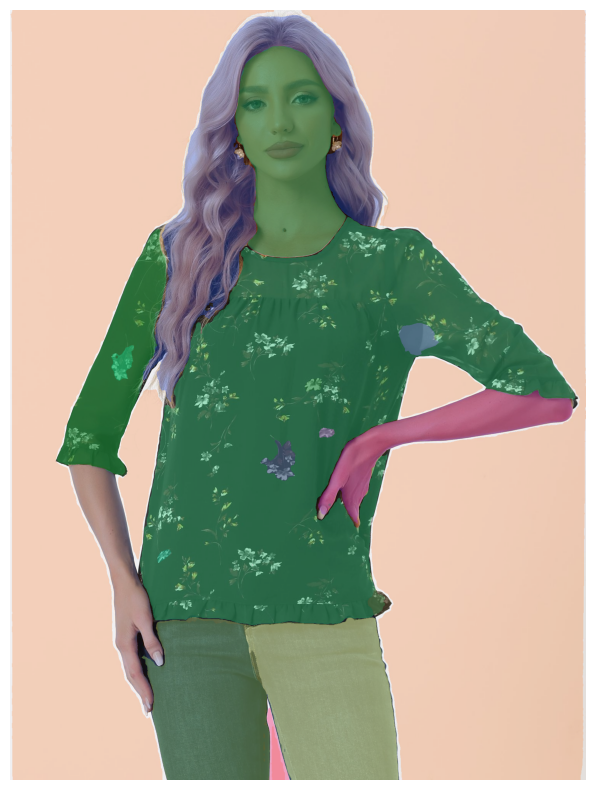

In [4]:
# 加载图像
image_path = "./images/image1.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # 转换为RGB

# 生成掩码
masks = mask_generator.generate(image)

# 可视化结果
import matplotlib.pyplot as plt

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:, :, i] = color_mask[i]
        ax.imshow(np.dstack((img, m * 0.35)))

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.savefig("output.png")
plt.show()

In [5]:
from segment_anything import SamPredictor, sam_model_registry

# 初始化预测器
predictor = SamPredictor(sam)

# 设置图像
predictor.set_image(image)

In [8]:
# 定义 show_anns 函数，用于显示自动分割结果
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    for ann in sorted_anns:
        m = ann['segmentation']
        plt.imshow(m, alpha=0.5)

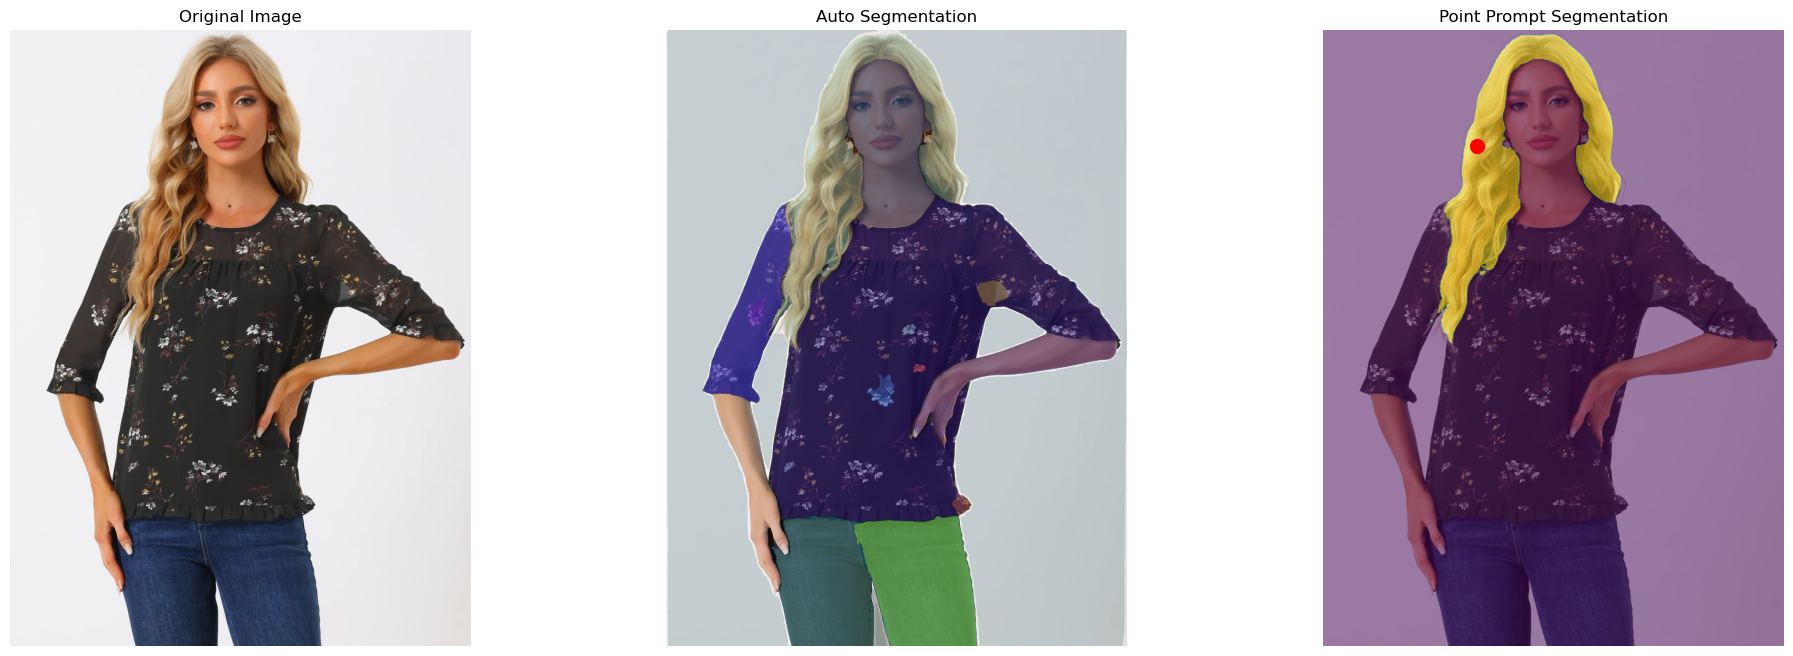

In [12]:
sam = sam_model_registry[model_type](checkpoint=checkpoint)
sam.to(device=device)

# 初始化预测器和自动掩码生成器
predictor = SamPredictor(sam)
mask_generator = SamAutomaticMaskGenerator(sam)

# 设置图像
predictor.set_image(image)

# 设置提示（点）
input_point = np.array([[500, 375]])  # 点坐标 [x, y]
input_label = np.array([1])  # 1表示前景，0表示背景

# 预测带提示的掩码
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,  # 返回多个掩码候选
)

# 选择最佳掩码
best_mask = masks[np.argmax(scores)]

# 使用自动掩码生成器生成没有提示的分割结果
auto_masks = mask_generator.generate(image)

# 定义 show_anns 函数，用于显示自动分割结果
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:, :, i] = color_mask[i]
        ax.imshow(np.dstack((img, m * 0.35)))

# 创建三列图：原图、自动分割、点提示分割
plt.figure(figsize=(24, 8))

# 第一列：原图
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

# 第二列：自动分割结果
plt.subplot(1, 3, 2)
plt.imshow(image)
show_anns(auto_masks)  # 传入 mask_generator.generate 的结果
plt.title("Auto Segmentation")
plt.axis('off')

# 第三列：点提示分割结果
plt.subplot(1, 3, 3)
plt.imshow(image)
plt.imshow(best_mask, alpha=0.5)  # 直接显示 best_mask
plt.scatter(input_point[:, 0], input_point[:, 1], c='r', s=100)  # 显示提示点
plt.title("Point Prompt Segmentation")
plt.axis('off')

# 保存并显示
plt.savefig("output_comparison.png")
plt.show()# 加载图像
# image_path = "path/to/your/image.jpg"
# image = cv2.imread(image_path)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

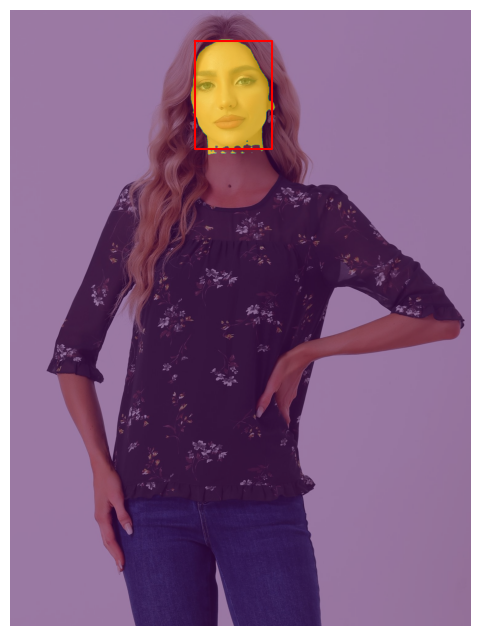

In [26]:
# 设置框提示
input_box = np.array([600, 100, 850, 450])  # [x1, y1, x2, y2]

masks, scores, logits = predictor.predict(
    box=input_box,
    multimask_output=False,
)

# 可视化
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.imshow(masks[0], alpha=0.5)
plt.plot([input_box[0], input_box[2], input_box[2], input_box[0], input_box[0]],
         [input_box[1], input_box[1], input_box[3], input_box[3], input_box[1]], 'r-')  # 显示框
plt.axis('off')
plt.savefig("output_box.png")
plt.show()

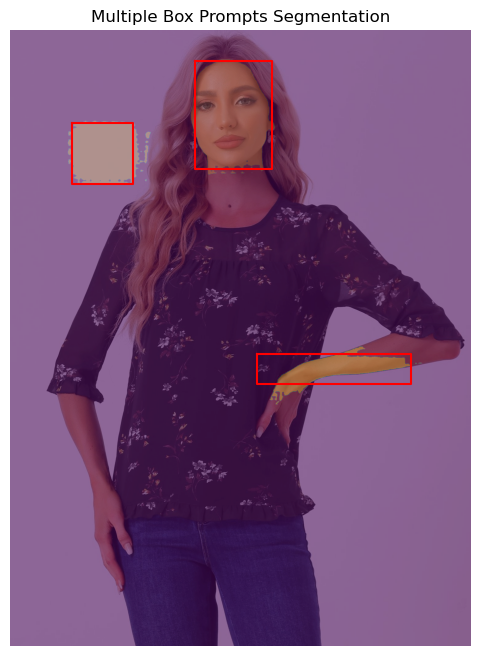

Box 1 confidence score: 0.9004
Box 2 confidence score: 0.8281
Box 3 confidence score: 0.7780


In [50]:
# 定义多个框提示
input_boxes = [
    np.array([600, 100, 850, 450]),  # 框1: [x1, y1, x2, y2]
    np.array([200, 300, 400, 500]),  # 框2: [x1, y1, x2, y2]
    np.array([800, 1050, 1300, 1150])    # 框3: [x1, y1, x2, y2]
]

# 存储所有掩码
all_masks = []
all_scores = []

# 遍历每个框进行预测
for box in input_boxes:
    masks, scores, logits = predictor.predict(
        box=box,
        multimask_output=False,  # 每次只返回一个最佳掩码
    )
    all_masks.append(masks[0])  # 取第一个掩码
    all_scores.append(scores[0])  # 存储置信度

# 可视化
plt.figure(figsize=(8, 8))
plt.imshow(image)

# 叠加所有掩码
for mask in all_masks:
    plt.imshow(mask, alpha=0.25)  # 叠加掩码，透明度0.3，可调整

# 绘制所有框
for box in input_boxes:
    plt.plot([box[0], box[2], box[2], box[0], box[0]],
             [box[1], box[1], box[3], box[3], box[1]], 'r-')  # 显示框

plt.title("Multiple Box Prompts Segmentation")
plt.axis('off')

plt.savefig("output_multi_boxes.png")
plt.show()

# 可选：打印每个框的置信度
for i, score in enumerate(all_scores):
    print(f"Box {i+1} confidence score: {score:.4f}")

In [51]:
from openai import OpenAI

client = OpenAI(
    # api_key="sk-xxx",
    api_key="sk-yj23jL5k8gUyumXRD235E926A6A24a2297AfFa884d8f14F5", 
    base_url="https://sre-oneapi.ux168.cn/v1",
)
completion = client.chat.completions.create(
    model="doubao-1-5-pro-32k-250115",
    messages=[
        {'role': 'system', 'content': 'You are a helpful assistant.'},
        {'role': 'user', 'content': '你是谁？'}],
    )
    
print(completion.model_dump_json())

{"id":"0217465913646063997cb373bf7d42ffbe60806e14e3ec51c917d","choices":[{"finish_reason":"stop","index":0,"logprobs":null,"message":{"content":"我是豆包，是由字节跳动研发的AI。我可以陪你畅快聊天，为你答疑解惑，不管是知识科普、文本创作，还是生活建议，我都能尽力提供帮助呢。 ","refusal":null,"role":"assistant","annotations":null,"audio":null,"function_call":null,"tool_calls":null}}],"created":1746591366,"model":"doubao-1-5-pro-32k-250115","object":"chat.completion","service_tier":"default","system_fingerprint":null,"usage":{"completion_tokens":46,"prompt_tokens":21,"total_tokens":67,"completion_tokens_details":{"accepted_prediction_tokens":null,"audio_tokens":null,"reasoning_tokens":0,"rejected_prediction_tokens":null},"prompt_tokens_details":{"audio_tokens":null,"cached_tokens":0}}}


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

In [ ]:
def clean_comparison_text(text):
    """
    清理API返回的数字比较文本，去除LaTeX标记、换行符、分隔线等，提取核心比较逻辑。
    
    参数:
        text (str): API返回的原始文本
        
    返回:
        str: 清理后的简洁文本
    """
    import re
    
    # 替换LaTeX标记为普通文本
    text = re.sub(r'\$\\([^$]+)\\\$', r'\1', text)  # 移除 \( ... \) 内的LaTeX
    text = re.sub(r'\$\$([^$]+)\$\$', r'\1', text)  # 移除 $$ ... $$ 内的LaTeX
    text = re.sub(r'\\\[([^$]+)\\\]', r'\1', text)  # 移除 \[ ... \] 内的LaTeX

    
    
    # 移除多余的换行符和分隔线
    text = re.sub(r'\n\s*-+\s*\n', '\n', text)  # 移除分隔线
    text = re.sub(r'\n\s*\n+', '\n', text)  # 合并多余换行
    text = text.replace('\n', ' ')  # 将单换行替换为空格
    
    # 清理多余的空格
    text = re.sub(r'\s+', ' ', text)
    
    # 移除特定的格式化标记（如 **...** 转为普通文本）
    text = re.sub(r'\*\*([^*]+)\*\*', r'\1', text)
    
    # 移除多余的括号和内部格式（如 (in 9.90) 简化为 9.90）
    text = re.sub(r'\(in ([0-9.]+)\)', r'\1', text)
    
    # 清理两端多余空格
    text = text.strip()
    
    return text

In [64]:
from openai import OpenAI

client = OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key="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",
)

completion = client.chat.completions.create(
  extra_headers={
    "HTTP-Referer": "<YOUR_SITE_URL>", # Optional. Site URL for rankings on openrouter.ai.
    "X-Title": "<YOUR_SITE_NAME>", # Optional. Site title for rankings on openrouter.ai.
  },
  # model="deepseek/deepseek-r1:free",
  model="meta-llama/llama-4-maverick:free",
  #model="deepseek/deepseek-r1:free",
  messages=[
    {
      "role": "user",
      "content": """
                Three people check into a hotel room that costs $30. They each pay $10. 
                Later, the manager realizes the room is only $25 and gives $5 to the bellboy to return to the guests. 
                The bellboy, unable to split $5 evenly, gives each guest $1 and keeps $2 as a tip. Now, each guest has paid $9 (totaling $27), 
                and the bellboy has $2, totaling $29. Where is the missing dollar?
                """
    },
    {'role': 'assistant', 'content': 'Give your answer in Chinese'}
  ]
)

original_text = completion.choices[0].message.content
print(original_text)
# print(clean_comparison_text(original_text))


## Step 1: Understand the initial transaction
Three people check into a hotel room that costs $30. They each pay $10, totaling $30.

## Step 2: Understand the refund and the bellboy's action
The manager realizes the room is only $25 and gives $5 to the bellboy to return to the guests. The bellboy gives each guest $1 and keeps $2 as a tip.

## Step 3: Calculate the total amount paid by the guests after the refund
Each guest initially paid $10. After receiving $1 back, they effectively paid $9 each. So, the total amount paid by the guests is $9 * 3 = $27.

## Step 4: Analyze the distribution of the $30
The hotel received $25 (the actual cost of the room), the bellboy kept $2, and the guests received $3 back ($1 each).

## Step 5: Understand where the money is distributed
The $30 initially paid is distributed as follows: $25 to the hotel, $3 returned to the guests, and $2 kept by the bellboy. So, $25 (hotel) + $3 (returned to guests) + $2 (bellboy's tip) = $30.

## Step 6: Address the app

In [58]:
print(original_text)

To determine whether 9.9 or 9.11 is larger, follow these steps:

1. **Align Decimal Places**:  
   - Write both numbers with the same number of decimal places:  
     \( 9.9 = 9.90 \) and \( 9.11 = 9.11 \).

2. **Compare Digit by Digit**:  
   - **Whole Number Part**: Both have \( 9 \), so they are equal here.  
   - **Tenths Place**:  
     - \( 9.90 \) has \( 9 \) in the tenths place.  
     - \( 9.11 \) has \( 1 \) in the tenths place.  
     - Since \( 9 > 1 \), \( 9.90 \) is already larger at this stage.  

3. **Conclusion**:  
   - No need to compare further decimal places (hundredths) because the tenths place determines the larger number.  

**Final Answer**:  
\( 9.9 \) is greater than \( 9.11 \).


In [65]:
import base64
from openai import OpenAI


def image_to_base64(image_path):
    extension = image_path.split('.')[-1].lower()
    mime_type = 'jpeg' if extension in ['jpg', 'jpeg'] else extension
    with open(image_path, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read()).decode('utf-8')
    return f"data:image/{mime_type};base64,{encoded_string}"

# 本地图片
base64_image = image_to_base64(image_path)

In [67]:
image_path_excel = "./images/excel1.png"
base64_excel = image_to_base64(image_path_excel)

In [75]:
image_path_report = "./images/report1.png"
base64_report = image_to_base64(image_path_report)

In [ ]:
from openai import OpenAI

# OCR提示词模板
ocr_prompt = """
Perform OCR on the provided image of an Excel table. Extract all visible text, including headers, cell contents, and any labels or annotations. Organize the output as follows:

1. **Table Structure**: Represent the table in a markdown table format, preserving rows and columns as they appear in the image. If the table has headers, include them.
2. **Additional Text**: List any text outside the table (e.g., titles, footnotes, or labels) separately.
3. **Formatting Notes**: Note any unclear or ambiguous text (e.g., due to image quality or overlapping elements).

If the table is too large or complex, summarize the key contents and indicate the total number of rows and columns. Ensure all text is transcribed accurately, including numbers, dates, and special characters. If any text is unreadable, mark it as [UNREADABLE].
"""

client = OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key="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",
)

completion = client.chat.completions.create(
  extra_headers={
    "HTTP-Referer": "<YOUR_SITE_URL>", # Optional. Site URL for rankings on openrouter.ai.
    "X-Title": "<YOUR_SITE_NAME>", # Optional. Site title for rankings on openrouter.ai.
  },
  extra_body={},
  model="meta-llama/llama-4-maverick:free",
  messages=[
    {
      "role": "user",
      "content": [
        {
          "type": "text",
          "text": ocr_prompt
        },
        {
          "type": "image_url",
          "image_url": {
            "url": base64_excel
          }
        }
      ]
    }
  ]
)
print(completion.choices[0].message.content)

| Address | Price | Beds | Baths |
| --- | --- | --- | --- |
| 1301 Robinson Court | $ 355,000 | 3 | 2 |
| 2479 North Bend Road | $ 109,900 | 1 | 1 |
| 897 Wiseman Street | $ 448,900 | 5 | 3 |
| 4960 Rosewood Lane | $ 849,900 | 3 | 2.5 |
| 4883 Hartland Avenue | $ 129,900 | 1 | 1 |
| 3007 Arthur Avenue | $ 119,000 | 2 | 1 |
| 2659 Crestview Terrace | $ 189,900 | 3 | 2 |
| 4803 Hoffman Avenue | $ 385,000 | 4 | 2 |
| 3385 Harter Street | $ 679,900 | 5 | [UNREADABLE] |
| 1233 Green Avenue | $ 189,900 | 3 | 2 |

**Additional Text**: EXCE3JITZ (located at the bottom right corner of the image)

**Formatting Notes**: 
- The text "EXCE3JITZ" appears at the bottom right, possibly as a label or annotation.
- The value under "Baths" for the row "3385 Harter Street" is unclear or ambiguous due to image quality or overlapping elements and is marked as [UNREADABLE].


In [72]:
ocr_prompt_report = """
Perform OCR on the provided image of an English-language report. Extract all visible text, including titles, headings, paragraphs, lists, tables, captions, footnotes, and any other elements. Organize the output as follows:

1. **Document Structure**: 
   - Reproduce the text in a structured format, preserving the hierarchy and formatting as closely as possible (e.g., use markdown headings for titles, bullet points for lists, markdown tables for tabular data).
   - For paragraphs, maintain the order and separate them clearly.
   - For tables, represent them in markdown table format, including headers if present.
   - For lists, use bullet points or numbered lists as appropriate.
   
2. **Metadata and Annotations**: 
   - Identify and list any metadata (e.g., report title, author, date) or annotations (e.g., page numbers, footnotes) separately.
   
3. **Formatting Notes**: 
   - Note any unclear or ambiguous text (e.g., due to image quality, overlapping elements, or handwriting).
   - If any text is unreadable, mark it as [UNREADABLE].
   
If the report is long or complex, summarize the key sections (e.g., title, abstract, main headings) and indicate the approximate page count or section count. Ensure all text is transcribed accurately, including numbers, dates, special characters, and proper nouns.
"""

completion = client.chat.completions.create(
  extra_headers={
    "HTTP-Referer": "<YOUR_SITE_URL>", # Optional. Site URL for rankings on openrouter.ai.
    "X-Title": "<YOUR_SITE_NAME>", # Optional. Site title for rankings on openrouter.ai.
  },
  extra_body={},
  model="meta-llama/llama-4-maverick:free",
  messages=[
    {
      "role": "user",
      "content": [
        {
          "type": "text",
          "text": ocr_prompt_report
        },
        {
          "type": "image_url",
          "image_url": {
            "url": base64_report
          }
        }
      ]
    }
  ]
)
print(completion.choices[0].message.content)

## MASTERING PIVOTTABLE
### Getting Started
- **What are PivotTables?**
  - A powerful tool for summarizing and analyzing large datasets.
  - Allows you to rotate and pivot data to gain different insights.

- **Creating a PivotTable**
  - Select a cell in your data range.
  - Go to `Insert` > `PivotTable`.
  - Choose the data range and where to place the PivotTable.

- **Basic PivotTable Structure**
  - **Rows**: Fields placed here will be displayed as row labels.
  - **Columns**: Fields placed here will be displayed as column labels.
  - **Values**: Fields to be summarized.
  - **Filters**: Fields to filter the PivotTable data.

### Deep-Dive Creative
- **Grouping Data**
  - Group dates by month, quarter, or year.
  - Group numeric data into ranges.

- **Custom Calculations**
  - Create calculated fields or items.
  - Use formulas to perform custom calculations.

- **Data Model Integration**
  - Use multiple tables in a single PivotTable.
  - Create relationships between tables.

### 

In [76]:
ocr_prompt_report = """
Perform OCR on the provided image of an English-language report. Extract all visible text, including titles, headings, paragraphs, lists, tables, captions, footnotes, and any other elements. Organize the output as follows:

1. **Document Structure**: 
   - Reproduce the text in a structured format, preserving the hierarchy and formatting as closely as possible (e.g., use markdown headings for titles, bullet points for lists, markdown tables for tabular data).
   - For paragraphs, maintain the order and separate them clearly.
   - For tables, represent them in markdown table format, including headers if present.
   - For lists, use bullet points or numbered lists as appropriate.
   
2. **Metadata and Annotations**: 
   - Identify and list any metadata (e.g., report title, author, date) or annotations (e.g., page numbers, footnotes) separately.
   
3. **Formatting Notes**: 
   - Note any unclear or ambiguous text (e.g., due to image quality, overlapping elements, or handwriting).
   - If any text is unreadable, mark it as [UNREADABLE].
   
If the report is long or complex, summarize the key sections (e.g., title, abstract, main headings) and indicate the approximate page count or section count. Ensure all text is transcribed accurately, including numbers, dates, special characters, and proper nouns.
"""

completion = client.chat.completions.create(
  extra_headers={
    "HTTP-Referer": "<YOUR_SITE_URL>", # Optional. Site URL for rankings on openrouter.ai.
    "X-Title": "<YOUR_SITE_NAME>", # Optional. Site title for rankings on openrouter.ai.
  },
  extra_body={},
  model="meta-llama/llama-4-maverick:free",
  messages=[
    {
      "role": "user",
      "content": [
        {
          "type": "text",
          "text": ocr_prompt_report
        },
        {
          "type": "image_url",
          "image_url": {
            "url": base64_report
          }
        }
      ]
    }
  ]
)
print(completion.choices[0].message.content)

# Mastering PivotTable

## Getting Started
**What is a PivotTable?**  
A tool in Microsoft Excel that summarizes large datasets to extract meaningful patterns.

**Why Use It?**
- Quick data analysis
- Easy comparison and segmentation
- Dynamic reporting

## Updating and Refreshing
- **Refresh**: Keeps your data synced with the source (PivotTable Analyze -> Refresh)
- **Change Data Source**: Update the source range easily for dynamic models

## Step-by-Step Creation
### Organize Data
- Ensure headers in the first row
- No blank rows or columns

### Insert PivotTable
- Insert -> PivotTable -> Select table/range -> Choose new or existing worksheet

### Organize Data
- **Filters**: For top-level segmentation (e.g., region, product line)
- **Rows**: Categories (e.g., months, departments)
- **Columns**: Sub-categories or comparisons
- **Values**: Metrics (e.g., Sum of Sales)

## Design & Formatting
- **Layout Options**: Compact, Tabular, or Outline view
- **Report Design**: Band rows, subtot